In [1]:
! pip install --user tensorflow-addons

In [ ]:
import os
os.kill(os.getpid(), 9)

In [7]:
! apt install aria2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aria2 is already the newest version (1.33.1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [8]:
! aria2c -x 16 -o dataset.tar.xz https://a.tmp.ninja/vrNOJcaC.tar.xz


05/13 19:39:32 [NOTICE] Downloading 1 item(s)

05/13 19:39:40 [NOTICE] Download complete: /content/dataset.tar.xz

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
781c50|OK  |    31MiB/s|/content/dataset.tar.xz

Status Legend:
(OK):download completed.


In [10]:
! tar xJvf dataset.tar.xz

dataset/trailer-01dljIcgiMw.jpg
dataset/trailer-01ZiLi4i_fM.jpg
dataset/trailer-02Yy1vihIKs.jpg
dataset/trailer-03T09FAWaIQ.jpg
dataset/trailer-05AfA24Q-eo.jpg
dataset/trailer-0_7KtgW11tw.jpg
dataset/trailer-07XbSk7Rjt4.jpg
dataset/trailer-08UfUj5U3dE.jpg
dataset/trailer-0aQ1R90UAxQ.jpg
dataset/trailer-0bMEGtUxajY.jpg
dataset/trailer-0bxIKcYUNCg.jpg
dataset/trailer-_0CR2N4xbfQ.jpg
dataset/trailer-0eAk6oNBSMU.jpg
dataset/trailer-0EnEBEZNkB4.jpg
dataset/trailer-0fKtglMo5qw.jpg
dataset/trailer-0hy54CpKeqk.jpg
dataset/trailer-0IX3Imm4osM.jpg
dataset/trailer-0JjRoh13vzY.jpg
dataset/trailer-0JOIK803Wz0.jpg
dataset/trailer-0_k3wCsOgqk.jpg
dataset/trailer-0LFfT44BlaQ.jpg
dataset/trailer-0lUJ89w3bBI.jpg
dataset/trailer-0mkyrd8twIY.jpg
dataset/trailer-0nycksytL1A.jpg
dataset/trailer-0O6YPAv1Hx8.jpg
dataset/trailer-0o8H7jg8E_w.jpg
dataset/trailer-0poXFSvX0_4.jpg
dataset/trailer-0PQ-ShkoaWI.jpg
dataset/trailer-0qqvyzamlns.jpg
dataset/trailer-0RBIY7Uts6s.jpg
dataset/trailer-0RI0Y3jI4S0.jpg
dataset/

In [2]:
import pandas as pd

dataset_path = 'dataset'
dataset = pd.read_csv(dataset_path + '/movies_selected.csv')
dataset = dataset.sample(frac=1, random_state=244).reset_index(drop=True)
dataset.head()

,Id,Name,Drama,Thriller,Comedy,Action,Romance
0,iJxBKglv2zw,The Guard,0,1,1,0,0
1,uecHd_qW1es,Waking Life,1,0,0,0,0
2,dKxgj5FxmZo,The Pink Panther,0,0,1,0,0
3,Hp_ZwQH2nfI,Away We Go,1,0,1,0,1
4,ArdNQUUcZOM,Angels & Demons,0,1,0,1,0


In [3]:
CLASSES = dataset.columns.values.tolist()[-5:]
CLASSES

['Drama', 'Thriller', 'Comedy', 'Action', 'Romance']

In [4]:
import tensorflow as tf
import tensorflow.keras.preprocessing.image as image_util
import random
import numpy as np

random.seed(244)

BATCH__SIZE=64
WIDTH = 224
HEIGHT = 224

class SpectrogramDataGenerator(tf.keras.utils.Sequence):

  def __init__(self, df, class_cols=CLASSES, batch_size=BATCH__SIZE, target_size=(HEIGHT, WIDTH),
               input_shape=(HEIGHT, WIDTH, 3), shuffle=True, speed_range=(1.0, 1.0),
               intensity_range=(1.0, 1.0)):
    self.df = df.copy()
    self.batch_size = batch_size
    self.class_cols = class_cols
    self.target_size = target_size
    self.input_shape = input_shape
    self.shuffle = shuffle
    self.speed_range = speed_range
    self.intensity_range = intensity_range

    self.n = len(self.df)

  def on_epoch_end(self):
    if self.shuffle:
      self.df.sample(frac=1).reset_index(drop=True)

  def __len__(self):
    return self.n // self.batch_size

  def __getitem__(self, index):
    start = index * self.batch_size
    end = start + self.batch_size
    batches = self.df[start:end]
    x, y = self.__get_data(batches)
    return x, y

  def __get_path(self, id):
    return dataset_path + '/trailer-' + id + '.jpg';

  def __get_input(self, path):
    img = image_util.load_img(path)
    img_width, img_height = img.size
    img = image_util.img_to_array(img)

    start = random.random()
    speed = random.uniform(*self.speed_range)

    target_width = int(speed * self.target_size[1])
    if target_width > img_width:
      target_width = img_width

    x_max = img_width - target_width
    x_start = int(start * x_max)
    img = img[:, x_start:x_start + target_width]
    img = tf.image.resize(img, (self.target_size[0], self.target_size[1]))

    intensity = random.uniform(*self.intensity_range)
    img = img + intensity
    img = np.clip(img, 0, 255)

    return img

  def __get_data(self, batches):
    x_batches = [self.__get_path(id) for id in batches['Id']]
    x_batches = [self.__get_input(path) for path in x_batches]
    x_batches = np.asarray(x_batches)

    y_batches = [batches[col] for col in self.class_cols]
    y_batches = list(zip(*y_batches))
    y_batches = np.asarray(y_batches)
    y_batches = y_batches.astype(np.float32)

    return x_batches, y_batches

In [5]:
n = dataset.shape[0]
train_n = int(n * 0.8)
valid_n = n - train_n

train_dataset = dataset[:train_n]
valid_dataset = dataset[train_n:n]

valid_dataset

,Id,Name,Drama,Thriller,Comedy,Action,Romance
2215,zH3O-CeZckE,Riddick,0,1,0,1,0
2216,HkZYbOH0ujw,It Follows,0,1,0,0,0
2217,BBqYaFEWBxI,Quantum of Solace,0,1,0,1,0
2218,OzNnCK5cd8Q,"The Good, the Bad, the Weird",0,0,1,1,0
2219,33hCrQCWfmw,Open Season,0,0,1,0,0
...,...,...,...,...,...,...,...
2764,WCWJL6D1SZA,How to Train Your Dragon 2,0,0,0,1,0
2765,284kahCx42s,Paycheck,0,1,0,1,0
2766,ngWBddVNVZs,Apocalypto,1,1,0,1,0
2767,GPcMKd_73Ys,Universal Soldier: Day of Reckoning,0,1,0,1,0


In [ ]:
train_gen = SpectrogramDataGenerator(train_dataset,
                                     speed_range=(0.8, 1.2),
                                     intensity_range=(-10, 10),)
valid_gen = SpectrogramDataGenerator(valid_dataset)

print(train_gen.n)
print(valid_gen.n)

2215
554


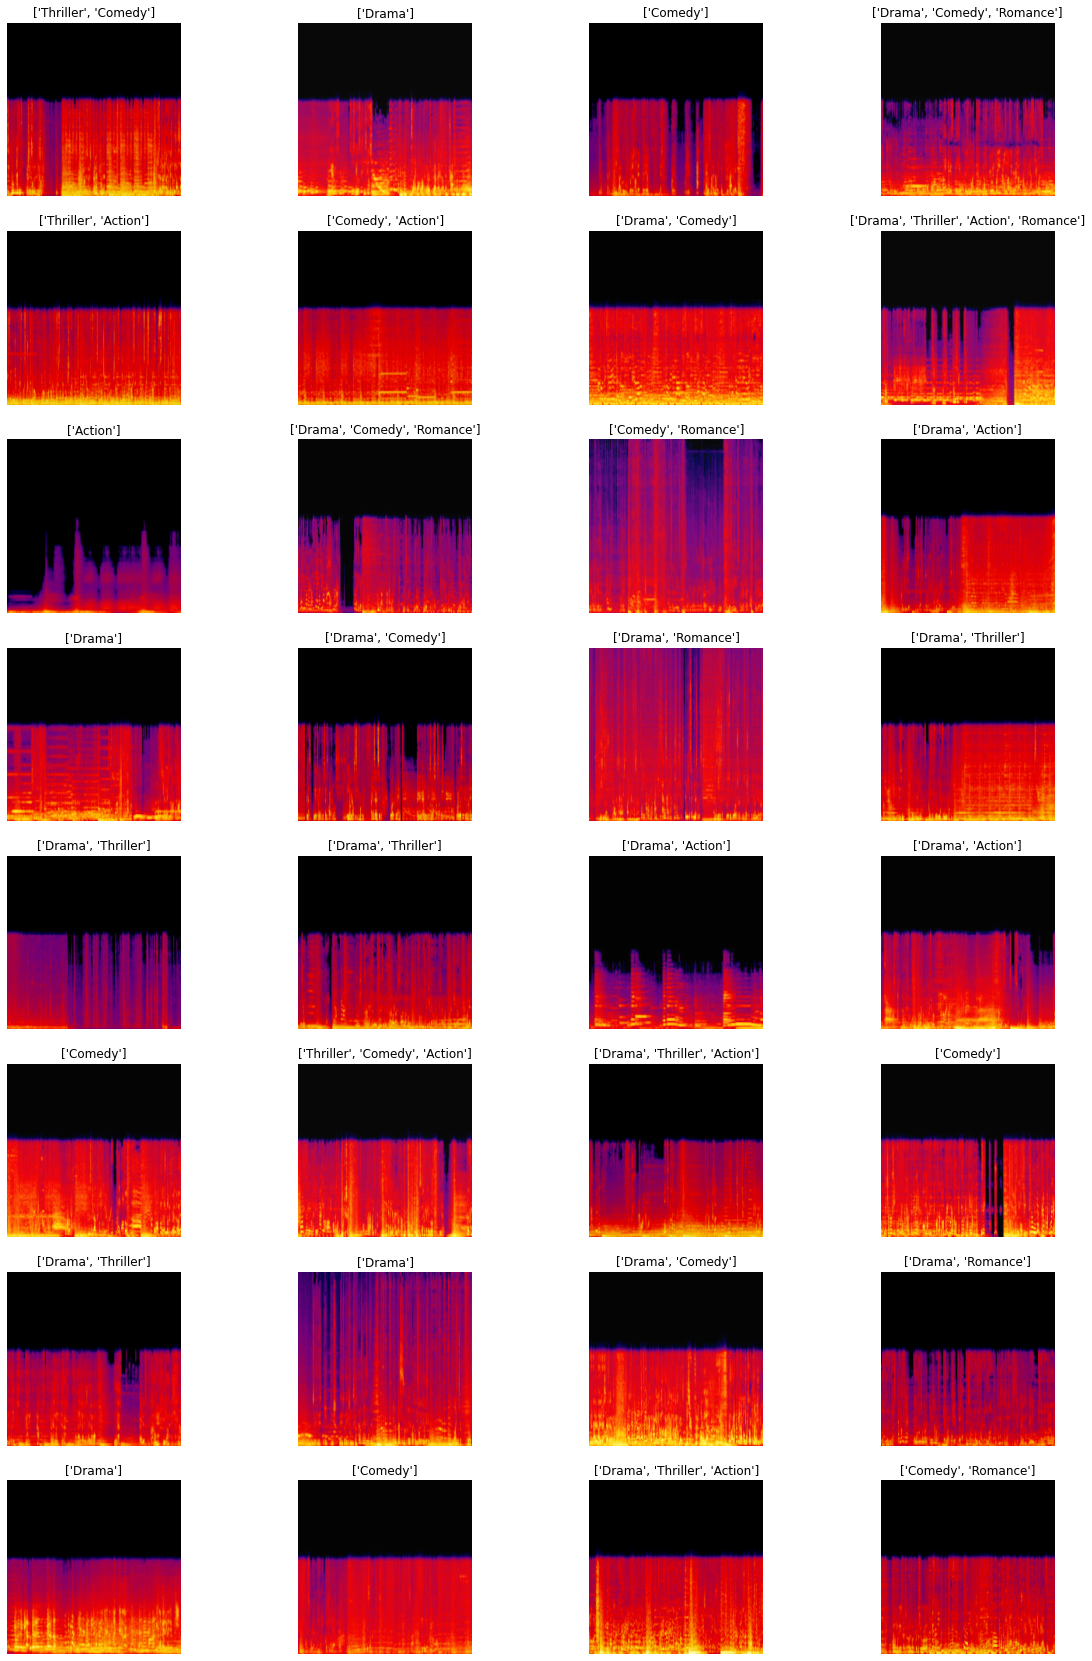

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dg_samples, dg_samples_class = train_gen[0]
dg_fig, dg_ax = plt.subplots(8, 4, figsize=(20, 30))
for i, (img, ax) in enumerate(zip(dg_samples, dg_ax.flatten())):
  img = img / 255
  ax.set_title(str([label for p, label in enumerate(CLASSES) if dg_samples_class[i][p] == 1]))
  ax.axis('off')
  ax.imshow(img)

In [ ]:
from tensorflow.keras.applications import VGG19

base_model = VGG19(include_top=False)
base_model.trainable = False

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

inputs = Input(shape=(224, 224, 3))
x = inputs
x = base_model(x, training=False)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(len(CLASSES), activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.compile(loss=SigmoidFocalCrossEntropy(), metrics=['binary_accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565

In [ ]:
import subprocess
from tensorflow.keras.callbacks import LambdaCallback

def save_model_and_upload(epoch = 0, logs = None):
  if epoch % 20 != 0:
    return

  model.save('model.h5')
  result = subprocess.run(
      ['curl', '-i', '-F', 'files[]=@model.h5', 'https://tmp.ninja/upload.php?output=text'],
      capture_output=True,
  )
  print(result.stdout)

save_model_callback = LambdaCallback(on_epoch_end=save_model_and_upload)

In [ ]:
EPOCHS=5

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    callbacks=[save_model_callback],
)

Epoch 1/5
34/34 [==============================] - 32s 914ms/step - loss: 9.6667 - binary_accuracy: 0.6534 - val_loss: 6.3514 - val_binary_accuracy: 0.6480
b'HTTP/2 200 \r\nserver: nginx/1.10.3\r\ndate: Thu, 13 May 2021 11:51:32 GMT\r\ncontent-type: text/plain; charset=UTF-8\r\n\r\nhttps://a.tmp.ninja/rDWyirKa.h5\n'
Epoch 2/5
34/34 [==============================] - 30s 895ms/step - loss: 7.2554 - binary_accuracy: 0.6493 - val_loss: 6.8751 - val_binary_accuracy: 0.6430
Epoch 3/5
34/34 [==============================] - 30s 900ms/step - loss: 6.9274 - binary_accuracy: 0.6404 - val_loss: 6.8778 - val_binary_accuracy: 0.6430
Epoch 4/5
34/34 [==============================] - 31s 902ms/step - loss: 6.9880 - binary_accuracy: 0.6400 - val_loss: 6.8730 - val_binary_accuracy: 0.6422
Epoch 5/5
34/34 [==============================] - 31s 903ms/step - loss: 6.9987 - binary_accuracy: 0.6365 - val_loss: 6.8813 - val_binary_accuracy: 0.6426


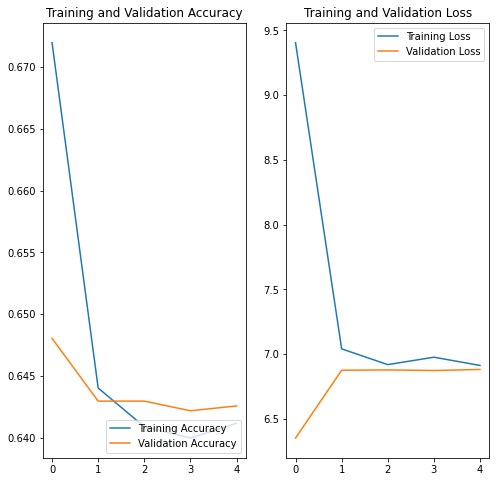

In [ ]:
def plot_acc_loss(history, epochs):
  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

plot_acc_loss(history, EPOCHS)

In [ ]:
base_model.trainable = True
model.compile(
    loss=SigmoidFocalCrossEntropy(),
    metrics=['binary_accuracy'],
    optimizer=keras.optimizers.RMSprop(learning_rate=.00001),
)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565

In [ ]:
FINAL_EPOCHS=200

final_history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=FINAL_EPOCHS,
    callbacks=[save_model_callback],
)

Epoch 1/200
34/34 [==============================] - 53s 2s/step - loss: 6.8480 - binary_accuracy: 0.6446 - val_loss: 6.8763 - val_binary_accuracy: 0.6426
b'HTTP/2 200 \r\nserver: nginx/1.10.3\r\ndate: Thu, 13 May 2021 11:54:49 GMT\r\ncontent-type: text/plain; charset=UTF-8\r\n\r\nhttps://a.tmp.ninja/OAYEUxck.h5\n'
Epoch 2/200
34/34 [==============================] - 51s 1s/step - loss: 6.9773 - binary_accuracy: 0.6380 - val_loss: 6.8482 - val_binary_accuracy: 0.6418
Epoch 3/200
34/34 [==============================] - 51s 2s/step - loss: 6.8874 - binary_accuracy: 0.6416 - val_loss: 6.8656 - val_binary_accuracy: 0.6422
Epoch 4/200
34/34 [==============================] - 51s 2s/step - loss: 6.8884 - binary_accuracy: 0.6414 - val_loss: 6.8771 - val_binary_accuracy: 0.6430
Epoch 5/200
34/34 [==============================] - 51s 2s/step - loss: 6.8498 - binary_accuracy: 0.6444 - val_loss: 6.8652 - val_binary_accuracy: 0.6430
Epoch 6/200
34/34 [==============================] - 51s 2s/ste

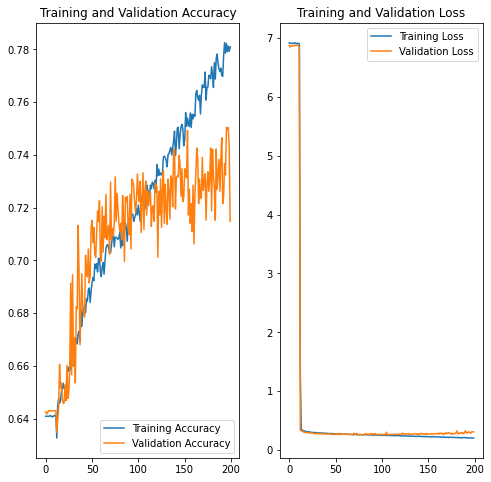

In [ ]:
plot_acc_loss(final_history, FINAL_EPOCHS)

In [ ]:
save_model_and_upload()

b'HTTP/2 200 \r\nserver: nginx/1.10.3\r\ndate: Thu, 13 May 2021 14:54:34 GMT\r\ncontent-type: text/plain; charset=UTF-8\r\n\r\nhttps://a.tmp.ninja/BBrAeAPZ.h5\n'


In [12]:
! aria2c -x 16 -o model.h5 https://a.tmp.ninja/BBrAeAPZ.h5


05/13 19:40:39 [NOTICE] Downloading 1 item(s)

05/13 19:40:45 [NOTICE] Download complete: /content/model.h5

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
68c43b|OK  |    32MiB/s|/content/model.h5

Status Legend:
(OK):download completed.


In [7]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.preprocessing.image as image_util
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
import numpy as np

model = keras.models.load_model('model.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565

In [9]:
import math

def split_spectrogram(path):
  img = image_util.load_img(path)
  img_width, img_height = img.size
  img = image_util.img_to_array(img)

  chunks_n = math.ceil(img_width / WIDTH)
  window_x = (img_width - WIDTH) // (chunks_n - 1)

  windows = [i * window_x for i in range(chunks_n)]
  imgs = [img[:, start:start + WIDTH] for start in windows]

  return imgs

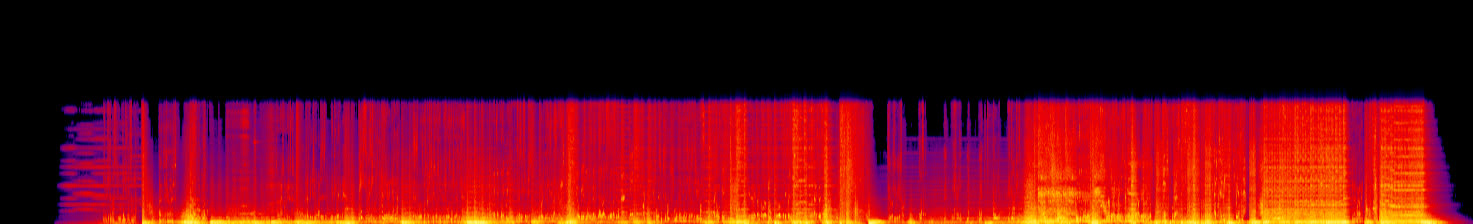

In [57]:
import PIL

test_id = 'BBqYaFEWBxI'
PIL.Image.open('dataset/trailer-' + test_id + '.jpg')

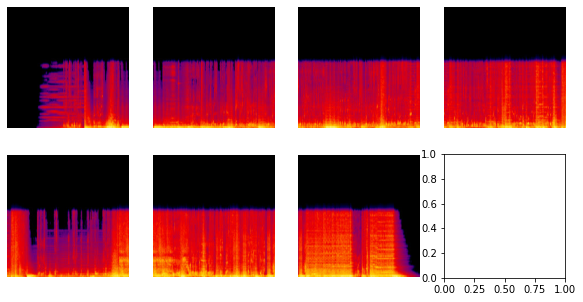

In [58]:
import matplotlib.pyplot as plt

dg_fig, dg_ax = plt.subplots(2, 4, figsize=(10,5))
spectrogram = split_spectrogram('dataset/trailer-' + test_id + '.jpg')
for i, (img, ax) in enumerate(zip(spectrogram, dg_ax.flatten())):
  img = img / 255
  ax.axis('off')
  ax.imshow(img)

In [59]:
test_pred = model.predict(np.asarray(spectrogram))
test_pred = np.around(test_pred)
print(valid_dataset[valid_dataset['Id'] == test_id])
print(test_pred)

               Id               Name  Drama  Thriller  Comedy  Action  Romance
2217  BBqYaFEWBxI  Quantum of Solace      0         1       0       1        0
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [23]:
def gen_x_y(batches):
  path_batches = ['dataset/trailer-' + id + '.jpg' for id in batches['Id']]
  img_batches = [split_spectrogram(path) for path in path_batches]

  y_batches = [batches[col] for col in CLASSES]
  y_batches = zip(*y_batches)
  xy_batches = list(zip(img_batches, y_batches))
  xy_batches = [(img, y) for imgs, y in xy_batches for img in imgs]

  x_batches, y_batches = zip(*xy_batches)
  x_batches = np.asarray(x_batches)
  y_batches = np.asarray(y_batches)
  y_batches = y_batches.astype(np.float32)

  return x_batches, y_batches

def gen_confusion_matrix(it):
  x, y_true = gen_x_y(it)
  y_pred = model.predict(x)
  y_pred = np.around(y_pred)

  for i, k in enumerate(CLASSES):
    y_true_class = y_true[:, i]
    y_pred_class = y_pred[:, i]

    print("Class: " + k)
    mat = tf.math.confusion_matrix(y_true_class, y_pred_class)
    print(mat)

gen_confusion_matrix(valid_dataset)

Class: Drama
tf.Tensor(
[[1323  113]
 [1625  570]], shape=(2, 2), dtype=int32)
Class: Thriller
tf.Tensor(
[[2115  326]
 [ 648  542]], shape=(2, 2), dtype=int32)
Class: Comedy
tf.Tensor(
[[2213  170]
 [ 601  647]], shape=(2, 2), dtype=int32)
Class: Action
tf.Tensor(
[[2498  145]
 [ 694  294]], shape=(2, 2), dtype=int32)
Class: Romance
tf.Tensor(
[[2792   17]
 [ 820    2]], shape=(2, 2), dtype=int32)
